In [3]:
!python -m site

sys.path = [
    'C:\\work\\PycharmProjects\\yolov5',
    'C:\\Users\\David\\.conda\\envs\\p37_yolov5\\python37.zip',
    'C:\\Users\\David\\.conda\\envs\\p37_yolov5\\DLLs',
    'C:\\Users\\David\\.conda\\envs\\p37_yolov5\\lib',
    'C:\\Users\\David\\.conda\\envs\\p37_yolov5',
    'C:\\Users\\David\\.conda\\envs\\p37_yolov5\\lib\\site-packages',
    'C:\\Users\\David\\.conda\\envs\\p37_yolov5\\lib\\site-packages\\win32',
    'C:\\Users\\David\\.conda\\envs\\p37_yolov5\\lib\\site-packages\\win32\\lib',
    'C:\\Users\\David\\.conda\\envs\\p37_yolov5\\lib\\site-packages\\Pythonwin',
]
USER_BASE: 'C:\\Users\\David\\AppData\\Roaming\\Python' (doesn't exist)
USER_SITE: 'C:\\Users\\David\\AppData\\Roaming\\Python\\Python37\\site-packages' (doesn't exist)
ENABLE_USER_SITE: True


In [4]:
import os
import sys
sys.path.append(r'C:\work\PycharmProjects\yolov5\yolov5')
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from glob import glob

from DiaperAIAU.Things import readyolov5txt2things
from DiaperAIAU.Interaction import PostureWrapper, getcount_persontouchobj, checkpointisinbox, xyxy2avexy, ActionWrapper, ComboactionWrapper
from utils.general import classtxt2classlist

# 單frame測試

In [6]:
video_path = r'C:\work\proj\auocare\2c_20210518-20210524\20210518AM\dlink_2c-20210518-115922-1621310362.mp4'
video = cv2.VideoCapture(video_path)
video_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_fps = int(video.get(cv2.CAP_PROP_FPS))
print('video_width',video_width,'video_height',video_height)
print('video_fps',video_fps)

video_width 1920 video_height 1080
video_fps 29


In [3]:
# label_path = r'C:\work\proj\auocare\video2img_fps1\dlink_2c-20210518-115922-1621310362.mp4\classes.txt'
# names = classtxt2classlist(label_path)
# print('names',names)

In [4]:
# txt_path = r'C:\work\proj\auocare\output_diaper\dlink_2c-20210518-115922-1621310362.mp4\labels\dlink_2c-20210518-115922-1621310362_1996.txt'
# activethings = readyolov5txt2things(txt_path,names,video_width,video_height)
# print('activethings',activethings)

In [5]:
# workarea = np.array([914,426,1245,666])
# filterarea = None
# postobj = PostureWrapper(workarea,filterarea)
# post = postobj.getpost(activethings)
# post

# 多frame紀錄

In [7]:
txt_dir_human = r'C:\work\proj\auocare\output_HDplot\dlink_2c-20210518-115922-1621310362.mp4\labels'
txt_dir_diaper = r'C:\work\proj\auocare\output_diaper\dlink_2c-20210518-115922-1621310362.mp4\labels'
label_path_diaper = r'C:\work\proj\auocare\video2img_fps1\dlink_2c-20210518-115922-1621310362.mp4\classes.txt'
video_name = r'dlink_2c-20210518-115922-1621310362'
output_dir = r'output_postfeature_diaper'
output_name = 'postfeature_05181159-nofixlocalfinishonlydiaper'

names_diaper = classtxt2classlist(label_path_diaper)
names_human = ['person']

# diaperworkarea = np.array([914,426,1245,666])
# personworkarea = np.array([895,299,1315,981])
# personworkarea = np.array([859,226,1353,1004])
diaperworkarea = None
personworkarea = None
filterarea = None
postobj = PostureWrapper(diaperworkarea,personworkarea,filterarea)

window_sec = 1
thres_p = 0.3
window = {'takediapernotinarea':int(window_sec*video_fps),
          'personinarea':int(window_sec*video_fps),
          'diaperinarea':int(window_sec*video_fps)}
threscount = {'takediapernotinarea':int(window_sec*video_fps*thres_p),
              'personinarea':int(window_sec*video_fps*thres_p),
              'diaperinarea':int(window_sec*video_fps*thres_p)}
actionobj = ActionWrapper(window,threscount)

forget_sec = 60
patient = int(video_fps*forget_sec)
comboactionobj = ComboactionWrapper(patient)

postdf = pd.DataFrame()
actiondf = pd.DataFrame()

for i in tqdm(range(51000)):
# for i in [13822]:
    txt_path_human = os.path.join(txt_dir_human,video_name+'_'+str(i)+'.txt')
    txt_path_diaper = os.path.join(txt_dir_diaper,video_name+'_'+str(i)+'.txt')
    activethings_human = readyolov5txt2things(txt_path_human,names_human,video_width,video_height) if os.path.exists(txt_path_human) else []
    activethings_diaper = readyolov5txt2things(txt_path_diaper,names_diaper,video_width,video_height) if os.path.exists(txt_path_diaper) else []
    activethings = activethings_human + activethings_diaper
    post = postobj.getpost(activethings)
    postdf = postdf.append(post,ignore_index=True)
    actionresult = actionobj.getaction(postdf)
    actionresult['status'],actionresult['nochangenum'] = comboactionobj.update(actionresult)
    actiondf = actiondf.append(actionresult,ignore_index=True)
    
#     print(i,post)
outputdf = pd.concat([postdf,actiondf],axis=1)
outputdf.to_csv(os.path.join(output_dir,output_name+'.csv'),index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51000/51000 [07:26<00:00, 114.12it/s]


In [8]:
encoder = {'waittrigger':0,'takediapernotinarea':1,'twopersoninarea':2,'replacediaper':3,'finish':4}
outputdf['status'].map(encoder)
outputdf['statusnum']=outputdf['status'].map(encoder)

In [9]:
outputdf.columns

Index(['count_person', 'count_diaper', 'count_inworkareaperson',
       'count_inworkareadiaper', 'count_inpersonworkareadiapers',
       'count_notinworkareaperson', 'count_notinworkareadiaper',
       'count_persontouchdiapernotinworkarea',
       'count_persontouchdiaperininworkarea', 'action_takediapernotinarea',
       'action_onepersoninarea', 'action_twopersoninarea',
       'action_diaperinarea', 'action_diaperinpersonarea', 'status',
       'nochangenum', 'statusnum'],
      dtype='object')

<AxesSubplot:>

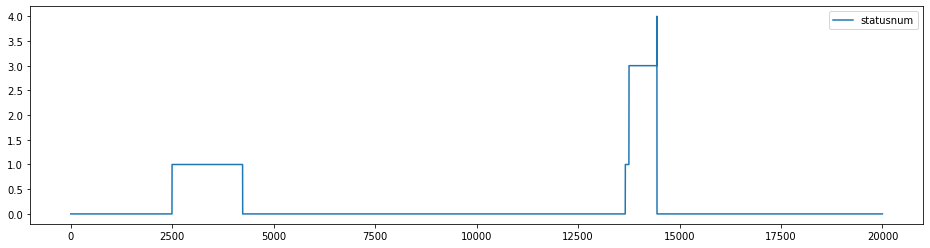

In [10]:
outputdf[:20000].plot(kind='line',y='statusnum',figsize=(16,4))

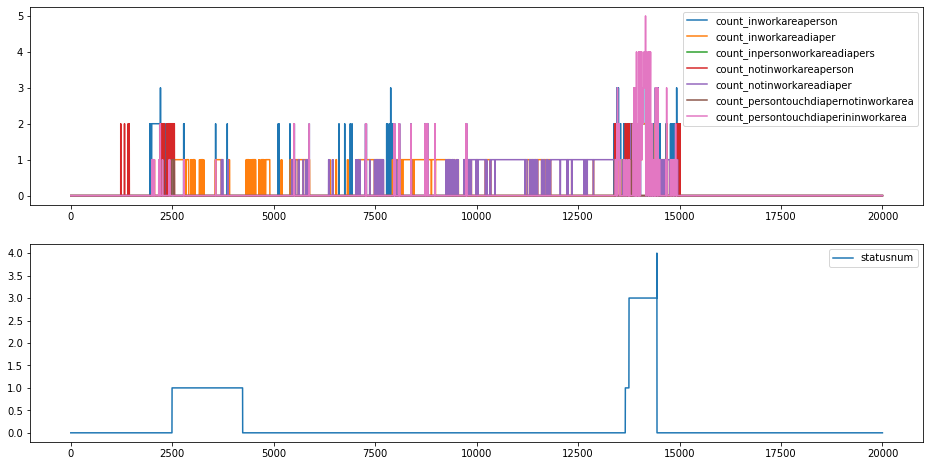

In [11]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(16,8))
outputdf[:20000].plot(kind='line',y=outputdf.columns[2:-2],ax=ax[0])
outputdf[:20000].plot(kind='line',y='statusnum',ax=ax[1])
# plt.show()
plt.savefig(os.path.join(output_dir,output_name+'-2plot.jpg'))

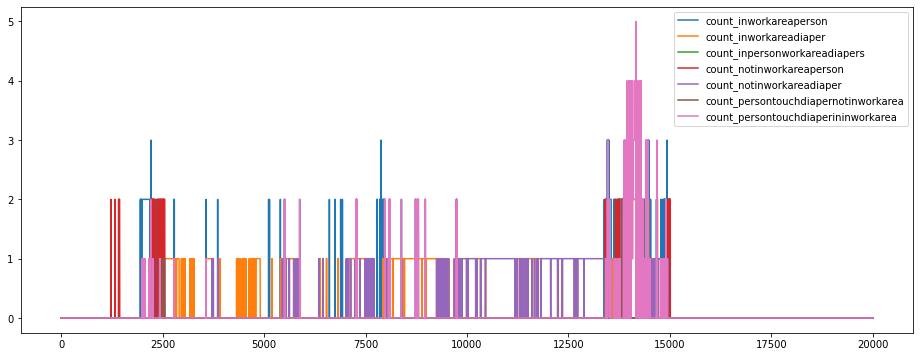

In [12]:
outputdf[:20000].plot(kind='line',y=outputdf.columns[2:-2],figsize=(16,6))
# plt.show()
plt.savefig(os.path.join(output_dir,output_name+'-1plot.jpg'))

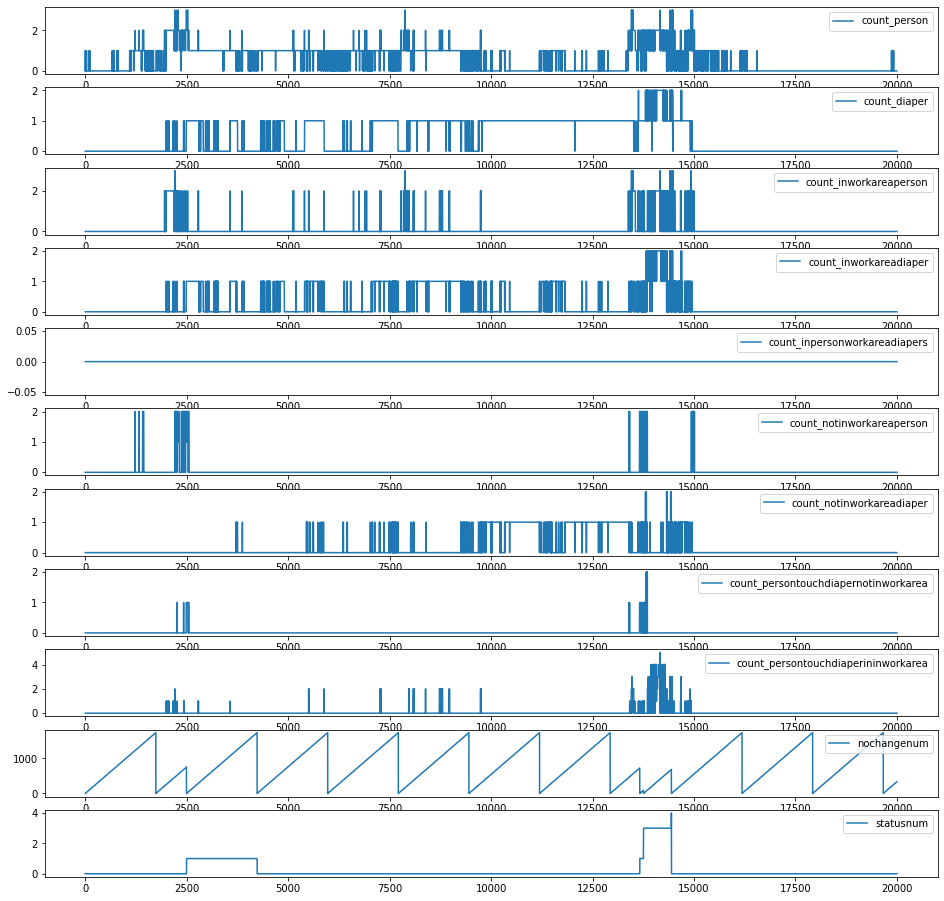

In [13]:
cols = outputdf.columns[outputdf.dtypes!='object']
fig,ax = plt.subplots(nrows=len(cols),ncols=1,figsize=(16,16))
for i,col in enumerate(cols):
    outputdf[:20000].plot(kind='line',y=col,ax=ax[i])
# plt.show()
plt.savefig(os.path.join(output_dir,output_name+'-allplot.jpg'))

In [13]:
# postdf = pd.read_csv('postfeature_05181159-1.csv',index_col=0)